# Predict New York City Taxi Trip Duration

### Xinzhu Han

https://www.kaggle.com/c/nyc-taxi-trip-duration/overview

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

### File descriptions
train.csv - the training set (contains 1458644 trip records)

test.csv - the testing set (contains 625134 trip records)

sample_submission.csv - a sample submission file in the correct format

### Data fields
id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds

Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

### 1. Load data

Fist step is to load dataset!

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [89]:
train=pd.read_csv('../data/raw/train.csv')
test=pd.read_csv('../data/raw/test.csv')
print("Total number of samples in train file : ", train.shape[0])
print("Total number of samples in test file : ", test.shape[0])

Total number of samples in train file :  1458644
Total number of samples in test file :  625134


### 2. Take a look at the dataset. 

In [45]:
print("A view of the train dataframe")
print(train.head())
print("\nColumns in train dataset : ", train.columns)
print("\n")
print("Overall description of the train dataset : ")
print(train.info())

A view of the train dataframe
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N    

### 3. Drop the duplicate data and fill null

See if id column has overlap, then delete the duplicate data.

In [46]:
train_id = set(train['id'].values)
test_id = set(test['id'].values)
print("Number of unique id in train dataset : ", len(train_id))
print("Number of unique id in test dataset : ", len(test_id))
common_ids = train_id.intersection(test_id)
print("Number of common id in the train and test datasets : ", len(common_ids))

Number of unique id in train dataset :  1458644
Number of unique id in test dataset :  625134
Number of common id in the train and test datasets :  0


So the id column doesn't have duplicate number. Then let's see the details of the target column: trip_duration.

In [47]:
target = train['trip_duration']
print("Longest trip duration {} or {} minutes: " .format(np.max(target.values), np.max(target.values)//60))
print("Smallest trip duration {} or {} minutes: ".format(np.min(target.values),np.min(target.values)//60))
print("Average trip duration : {} or {} minutes".format(np.mean(target.values), np.mean(target.values)//60))

Longest trip duration 3526282 or 58771 minutes: 
Smallest trip duration 1 or 0 minutes: 
Average trip duration : 959.4922729603659 or 15.0 minutes


Check if there are some nulls in dataset. If so, fill it with mean.

In [48]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [49]:
test.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

So the train and test data don't have null.

Limit area of investigation to within the NY City borders. Change the formatting of the date variables (`pickup_datetime` and `dropoff_datetime`)

In [50]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

### 4. Visualization

See if some data seems have notible difference.

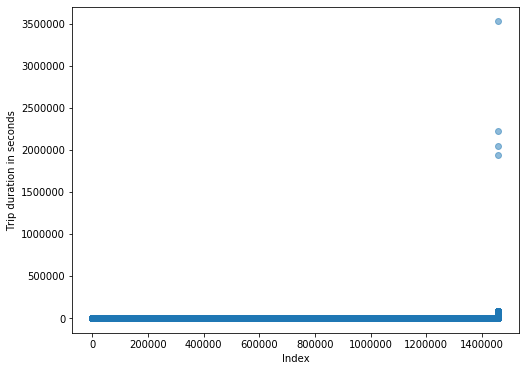

In [8]:
f = plt.figure(figsize=(8,6))
plt.scatter(range(len(target)), np.sort(target.values), alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Trip duration in seconds')
plt.show()

Yeah! Data actually have a few point have notible difference.

A log transform can help us to see if notable patterns emerge in the data

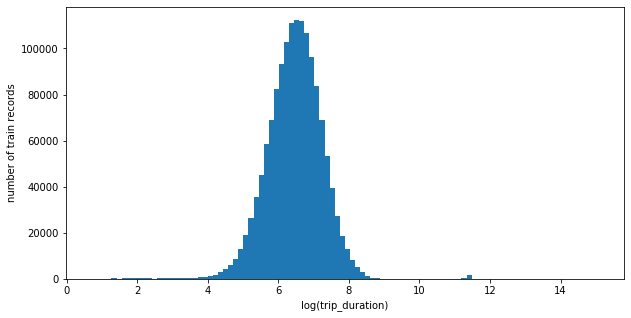

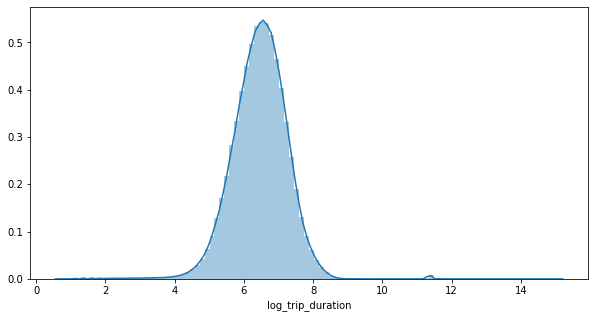

In [56]:
plt.rcParams['figure.figsize'] = [10, 5]
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

The number of trips over time.

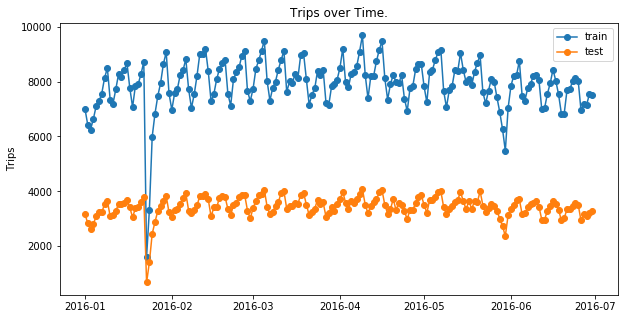

In [57]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

A few points stand out in this figure.

How the two vendors differ in their respective mean trip durations:

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

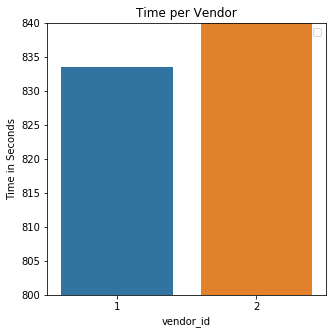

In [62]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(5,5))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

The number of trips with changes of passengers count column.

Maximum number of passengers on a trip :  9
Minimum number of passengers on a trip :  0
Average number of passengers on a trip :  1.6645295219395548


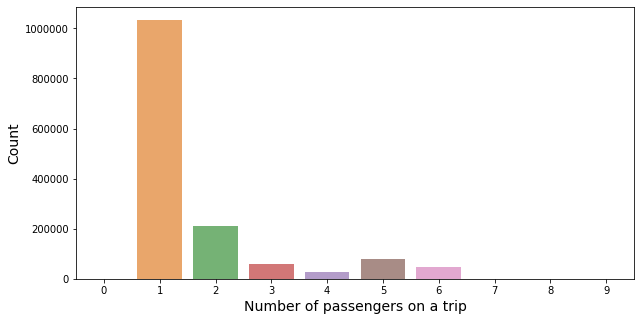

In [10]:
pass_count = train['passenger_count']
print("Maximum number of passengers on a trip : ", np.max(pass_count.values))
print("Minimum number of passengers on a trip : ", np.min(pass_count.values))
print("Average number of passengers on a trip : ", np.mean(pass_count.values))

f = plt.figure(figsize=(10,5))
pass_count = train['passenger_count'].value_counts()
sns.barplot(pass_count.index, pass_count.values, alpha=0.7)
plt.xlabel('Number of passengers on a trip', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

The numbers change with store_and_fwd_flag column.

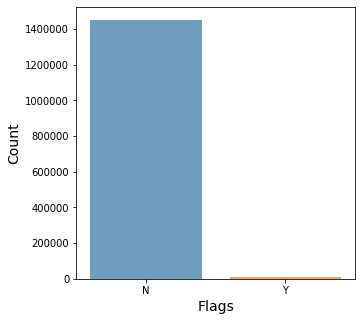

In [11]:
flags = train['store_and_fwd_flag'].value_counts()

f = plt.figure(figsize=(5,5))
sns.barplot(flags.index, flags.values, alpha=0.7)
plt.xlabel('Flags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Pickups and dropoffs in the whole month.

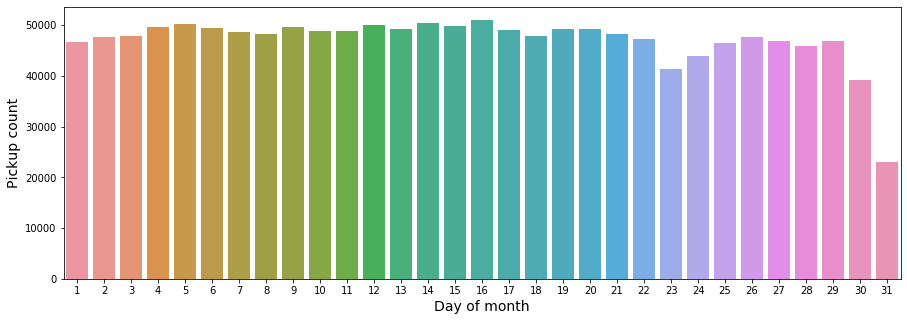

In [12]:
train1=train
train1['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train1['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

train1['pickup_day'] = train['pickup_datetime'].dt.day
train1['pickup_month'] = train['pickup_datetime'].dt.month
train1['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train1['pickup_hour'] = train['pickup_datetime'].dt.hour

train1['drop_day'] = train['dropoff_datetime'].dt.day
train1['drop_month'] = train['dropoff_datetime'].dt.month
train1['drop_weekday'] = train['dropoff_datetime'].dt.weekday
train1['drop_hour'] = train['dropoff_datetime'].dt.hour

f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_day', data=train1)
plt.xlabel('Day of month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

How many pickups for each month?

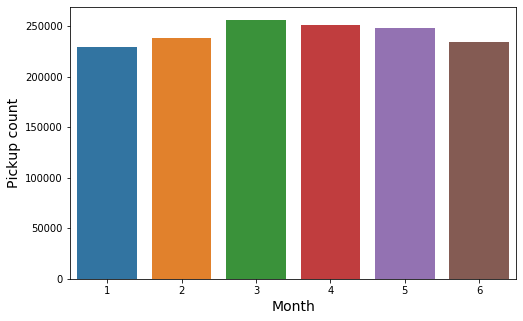

In [13]:
f = plt.figure(figsize=(8,5))
sns.countplot(x='pickup_month', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

The trip duration and passenger count.

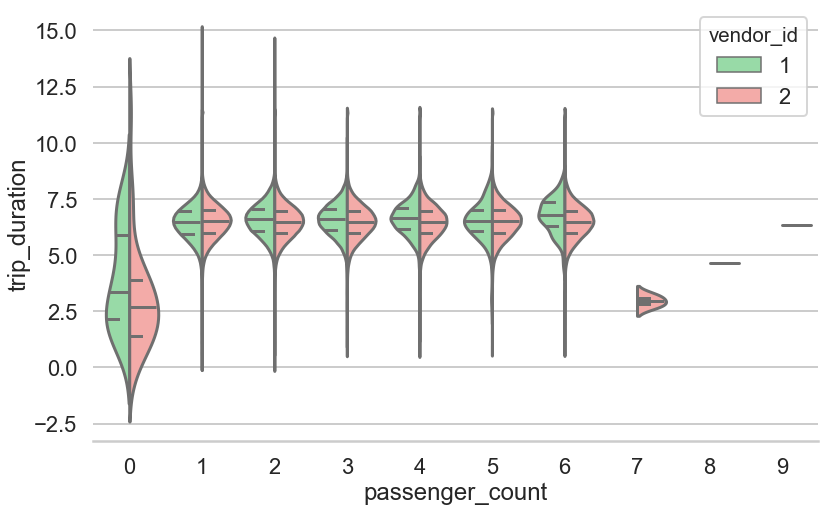

In [14]:
f = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
train_data2 = train.copy()
train_data2['trip_duration']= np.log(train['trip_duration'])
sns.violinplot(x="passenger_count", y="trip_duration", hue="vendor_id", data=train_data2, split=True,
               inner="quart",palette={1: "g", 2: "r"})

sns.despine(left=True)

### 5. Split the dataset into training and testing.

Split the dataset into 70% training and 30% testing using train_test_split.

In [25]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 

%matplotlib inline
import numpy as np
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
 
from sklearn.datasets import load_boston
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import r2_score

In [69]:
from sklearn.model_selection import train_test_split
X=train[['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
y=train[['trip_duration']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.30, random_state = 1)

### 6. Create a trasformer instance

#### Hyperparameter tuning

In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [76]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()
parameters = {
              'objective': ['reg:linear'],
              'learning_rate': [0.3, 0.5, 0.7], 
              'max_depth': [7, 10, 15],
              'subsample': [0.7],
              'n_estimators': [100],
              'eval_metric': ['rmse']}
xgb_grid = GridSearchCV(xgb, parameters, cv=3, n_jobs=-1, verbose=True)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 16.9min finished


[21:51:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eval_metric': ['rmse'],
                         'learning_rate': [0.3, 0.5, 0.7],
                         

In [78]:
best_grid_randomsearch= xgb_grid.best_estimator_
best_grid_randomsearch

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.3,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

#### Use the best_grid as the regerssor and apply it into one of the steps of pipeline.

In [79]:
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.3,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
xgb_model=Pipeline(steps=([('scaler',StandardScaler()),('regressor', regressor)]))

In [100]:
xgb=xgb_model.fit(X_train,y_train)

[20:40:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Predict the target trip duration with applying X_test into xgb_model. Then calculate the mean absolute error and r2 score of y_test and y_pred.

In [101]:
y_pred = xgb_model.predict(X_test);
mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print("The model performance for testing set from grid search")
print("--------------------------------------")
print('mean absoulte error is {}'.format(mae))
print('R2 score is {}'.format(r2))
print('Improvement of {:0.2f}%.'.format( 100 * (r2- r2) / r2))

The model performance for testing set from grid search
--------------------------------------
mean absoulte error is 452.418212454404
R2 score is -0.2703700512898737
Improvement of -0.00%.
